In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import requests
from PIL import Image
import io
import string

vocab = string.ascii_letters + string.digits


def get_captcha_image():
    response = requests.get(
        "https://apply.jtw.beijing.gov.cn/apply/app/common/validCodeImage"
    )
    cookie = response.cookies.get_dict()  # 获取cookie
    image = Image.open(io.BytesIO(response.content))  # 获取图片
    return image, cookie


def check_captcha(captcha_text, cookie):
    headers = {"cookie": f"JSESSIONID={cookie['JSESSIONID']}"}
    url = f"https://apply.jtw.beijing.gov.cn/apply/app/common/checkValidCode?validCode={captcha_text}"
    response = requests.get(url, headers=headers)
    return response.json()


# 图像预处理
def preprocess_image(image):
    image = image.convert("L")  # 灰度化
    threshold = 200
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    image = image.point(table, '1')  # 二值化
    return image

In [3]:
# list all ttf fonts in the font directory
import os

font_dir = "fonts"
fonts = []
for root, dirs, files in os.walk(font_dir):
    for file in files:
        if file.endswith(".ttf"):
            fonts.append(os.path.join(root, file))
print(fonts)

['fonts/DejaVuSansMono-Regular.ttf', 'fonts/NotoSerif-Regular.ttf', 'fonts/DejaVuSerif-Regular.ttf', 'fonts/Amiri-Regular.ttf', 'fonts/KawkabMono-Regular.ttf', 'fonts/Catamaran-Regular.ttf', 'fonts/DavidLibre-Regular.ttf', 'fonts/NotoSans-Regular.ttf', 'fonts/LinusLibertinus-Regular.ttf', 'fonts/Lato-Regular.ttf', 'fonts/Halant-Regular.ttf', 'fonts/NotoSansMono-Regular.ttf', 'fonts/InconsolataSugar-Regular.ttf', 'fonts/IBMPlexMono-Regular.ttf', 'fonts/DejaVuSansMonoForConso1as-Regular.ttf', 'fonts/Cousine-Regular.ttf', 'fonts/DejaVuSans-Regular.ttf']


In [28]:
import string
import random
from captcha.image import ImageCaptcha,random_color,SMOOTH,ColorTuple
from PIL import Image
from PIL.ImageDraw import Draw

def create_noise_line(image: Image, color: ColorTuple) -> Image:
    w, h = image.size
    x1 = random.randint(0, w)
    x2 = random.randint(0, w)
    y1 = random.randint(0, h)
    y2 = random.randint(0, h)
    points = [x1, y1, x2, y2]
    Draw(image).line(points, fill=color, width=1)
    return image

def generate_image(chars: str) -> Image:
    """Generate the image of the given characters.

    :param chars: text to be generated.
    """
    image = ImageCaptcha(width=112,height=35,fonts=fonts)
    # background = random_color(238, 255)
    color = random_color(1, 200, 255)
    im = image.create_captcha_image(chars, color, (255, 255, 255) )
    image.create_noise_dots(im, color,1,30)
    create_noise_line(im, color)
    create_noise_line(im, color)
    # im = im.filter(SMOOTH)
    return im

def generate_captcha():
    captcha = ''.join(random.choices(vocab, k=4))
    image = generate_image(captcha)
    return image, captcha

def generate_simple_captcha():
    captcha = ''.join(random.choices(vocab, k=4))
    image = ImageCaptcha(width=112,height=35,font_sizes=[36]).generate_image(captcha)
    return image, captcha


(112, 35)


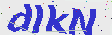

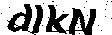

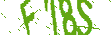

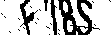

In [29]:
# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display

display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
# generate captcha dataset
from torch.utils.data import Dataset
import concurrent.futures
from torchvision import transforms
import torch


def generate_and_preprocess(simple=False):
    if simple:
        image, captcha = generate_simple_captcha()
    else:
        image, captcha = generate_captcha()
    image = preprocess_image(image)
    image_tensor = transforms.ToTensor()(image)

    # Generate one-hot encoded label
    label = torch.zeros(4, 62)
    for i, char in enumerate(captcha):
        label[i][vocab.index(char)] = 1

    return image_tensor, label


class CaptchaDataset(Dataset):
    def __init__(self, n=1000,simple=False):
        self.data = []
        self.labels = []

        with concurrent.futures.ProcessPoolExecutor() as executor:
            results = list(executor.map(generate_and_preprocess, [simple] * n))

        for image_tensor, label in results:
            self.data.append(image_tensor)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [53]:
from models.cnn import CaptchaOCR
model = CaptchaOCR()
import os

if os.path.exists("captcha_ocr.pth"):
    model.load_state_dict(torch.load("captcha_ocr.pth"))

/tmp/ipykernel_4183378/562505936.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("captcha_ocr.pth"))


In [19]:
from models.transformer import CaptchaSolverWithTransformer
model = CaptchaSolverWithTransformer()
import os

if os.path.exists("captcha_transformer.pth"):
    model.load_state_dict(torch.load("captcha_transformer.pth"))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_4183378/265152414.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to

In [40]:
from models.cnn_transformer import CaptchaSolverWithCNNTransformer

model = CaptchaSolverWithCNNTransformer()
import os

if os.path.exists("captcha_cnn_transformer.pth"):
    model.load_state_dict(torch.load("captcha_cnn_transformer.pth"))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [59]:
from torch.utils.data import DataLoader

dataset = CaptchaDataset(50000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [60]:
# train model
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(5):
    for x, y in tqdm(dataloader):
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f"Loss: {loss.item()} Accuracy: {accuracy.item()}")

100%|██████████| 1562/1562 [01:01<00:00, 25.20it/s]


Loss: 0.9976024627685547 Accuracy: 0.671875


100%|██████████| 1562/1562 [01:05<00:00, 24.00it/s]


Loss: 0.8000314831733704 Accuracy: 0.78125


100%|██████████| 1562/1562 [00:59<00:00, 26.24it/s]


Loss: 0.8939096927642822 Accuracy: 0.71875


100%|██████████| 1562/1562 [00:55<00:00, 28.23it/s]


Loss: 0.7746679186820984 Accuracy: 0.7578125


100%|██████████| 1562/1562 [00:53<00:00, 28.93it/s]

Loss: 0.19961082935333252 Accuracy: 0.921875


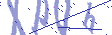

xPqh


[('XPQh', 0.33216238021850586),
 ('XpQh', 0.14888665080070496),
 ('xPQh', 0.13627782464027405),
 ('XPqh', 0.12827244400978088),
 ('xpQh', 0.06108442321419716),
 ('Xpqh', 0.05749613419175148),
 ('xPqh', 0.05262694135308266),
 ('xpqh', 0.023589210584759712),
 ('XPVh', 0.018817078322172165),
 ('XpVh', 0.008434463292360306)]

In [66]:
# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0)
y_pred = model.predict_all_possible(x)
y_pred

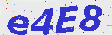

[('k448', 0.7556287050247192),
 ('h448', 0.17285388708114624),
 ('k443', 0.028829650953412056),
 ('k44B', 0.01767926849424839),
 ('h443', 0.0065949284471571445),
 ('h44B', 0.004044222179800272),
 ('Z448', 0.003962393384426832),
 ('L448', 0.0026515729259699583),
 ('G448', 0.002635649172589183),
 ('x448', 0.002047312445938587)]

In [68]:
# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0)
y_pred = model.predict_all_possible(x)
y_pred

In [63]:
# save model
if model.__class__.__name__ == "CaptchaOCR":
    torch.save(model.state_dict(), "captcha_ocr.pth")
elif model.__class__.__name__ == "CaptchaSolverWithTransformer":
    torch.save(model.state_dict(), "captcha_transformer.pth")